In [1]:
import h5py
import gc_utils
import numpy as np
import matplotlib.pyplot as plt

In [2]:
simulation = "m12i"
sim_dir = "/Users/z5114326/Documents/simulations/"

proc_file = sim_dir + simulation + "/" + simulation + "_processed.hdf5"
proc_data = h5py.File(proc_file, "r")  # open processed data file

In [ ]:
it = 0
snap = 214

it_id = gc_utils.iteration_name(it)
snap_id = gc_utils.snapshot_name(snap)

props = ["inc", "lz_norm", "r", "form_time", "ecc", "logm_tform"]
prop_locs = ["snap", "snap", "snap", "sour", "snap", "sour"]
prop_scale = ["linear", "linear", "log", "linear", "linear", "linear"]

prop_dict = {"in_situ_s": {}, "in_situ_d": {}, "ex_situ_s": {}, "ex_situ_d": {}}

sour_dat = proc_data[it_id]["source"]
ana_mask = sour_dat["analyse_flag"][()] == 1

src_gc_ids = sour_dat["gc_id"][ana_mask]
src_grp_ids = sour_dat["group_id"][ana_mask]
src_tdis_s = sour_dat["t_dis"][ana_mask]

snap_dat = proc_data[it_id]["snapshots"][snap_id]
acc_mask = snap_dat["now_accreted"][()] == 1
snp_gc_ids = snap_dat["gc_id"][acc_mask]

is_lst = []
id_lst = []
es_lst = []
ed_lst = []

for gcid in snp_gc_ids:
    gc_idx = np.where(src_gc_ids == gcid)[0][0]
    grp = src_grp_ids[gc_idx]
    tdis = src_tdis_s[gc_idx]

    if (grp == 0) & (tdis < 0):
        is_lst.append(gcid)

    elif (grp == 0) & (tdis > 0):
        id_lst.append(gcid)

    elif (grp != 0) & (tdis < 0):
        es_lst.append(gcid)

    elif (grp != 0) & (tdis > 0):
        ed_lst.append(gcid)


prop_dict["in_situ_s"]["gcid"] = np.array(is_lst)
prop_dict["in_situ_d"]["gcid"] = np.array(id_lst)
prop_dict["ex_situ_s"]["gcid"] = np.array(es_lst)
prop_dict["ex_situ_d"]["gcid"] = np.array(ed_lst)

for gc_type in prop_dict.keys():
    for prop, prop_loc in zip(props, prop_locs):
        prop_lst = []
        if prop_loc == "sour":
            for gcid in prop_dict[gc_type]["gcid"]:
                gcid_idx = np.where(sour_dat["gc_id"][ana_mask] == gcid)[0][0]
                prop_lst.append(sour_dat[prop][ana_mask][gcid_idx])

        else:
            for gcid in prop_dict[gc_type]["gcid"]:
                gcid_idx = np.where(snap_dat["gc_id"] == gcid)[0][0]
                prop_lst.append(snap_dat[prop][gcid_idx])

        prop_dict[gc_type][prop] = np.array(prop_lst)

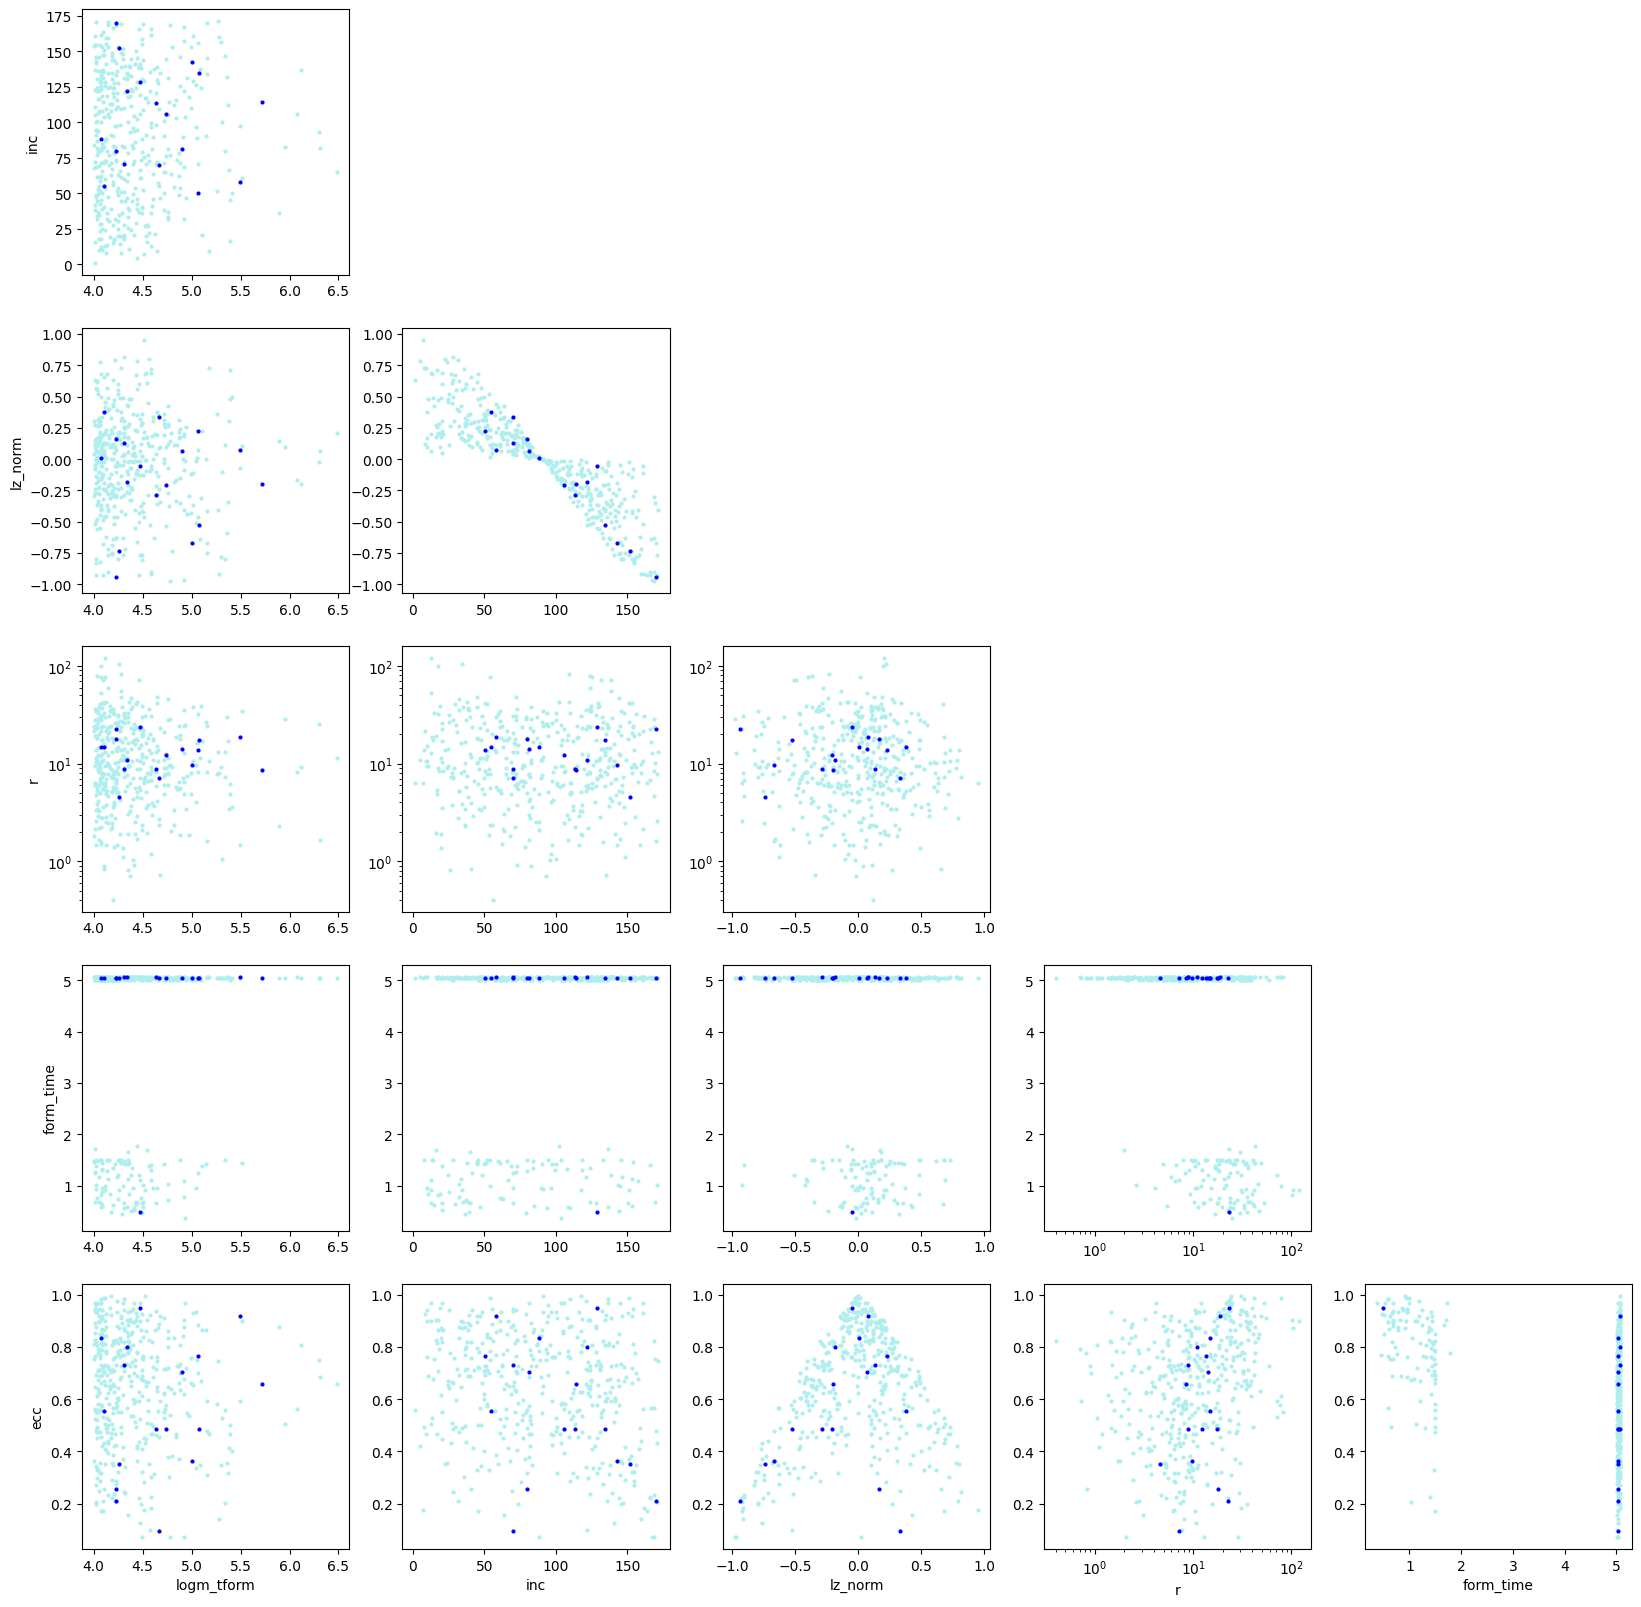

In [123]:
num_rows = len(props) - 1
num_cols = len(props) - 1

type_check = ["in_situ_s", "in_situ_d", "ex_situ_s", "ex_situ_d"]
type_check = ["in_situ_s", "in_situ_d"]
type_check = ["ex_situ_s", "ex_situ_d"]

plot_c = ["r", "pink", "blue", "paleturquoise"]
plot_m = [".", ".", ".", "."]
plot_s = [4, 4, 4, 4]
plot_z = [1, 0, 1, 0]

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))

# for i, ax in enumerate(axs.flat):
for (i, j), ax in np.ndenumerate(axs):
    if j > i:
        ax.axis("off")

    else:
        prop_x = props[j - 1]
        x_scale = prop_scale[j - 1]

        prop_y = props[i]
        y_scale = prop_scale[i]

        for type_i, gc_type in enumerate(prop_dict.keys()):
            if gc_type in type_check:
                x = prop_dict[gc_type][prop_x]
                y = prop_dict[gc_type][prop_y]

                ax.scatter(x, y, s=plot_s[type_i], c=plot_c[type_i], zorder=plot_z[type_i])
                ax.set_xscale(x_scale)
                ax.set_yscale(y_scale)

        if i == num_rows - 1:
            ax.set_xlabel(prop_x)

        if j == 0:
            ax.set_ylabel(prop_y)


In [110]:
for gc_type in prop_dict.keys():
    pos_lst = []
    for gcid in prop_dict[gc_type]["gcid"]:
        gcid_idx = np.where(snap_dat["gc_id"] == gcid)[0][0]
        pos_lst.append(snap_dat["pos.xyz"][gcid_idx])

    prop_dict[gc_type]["pos.xyz"] = np.array(pos_lst)

Text(0, 0.5, 'y [kpc]')

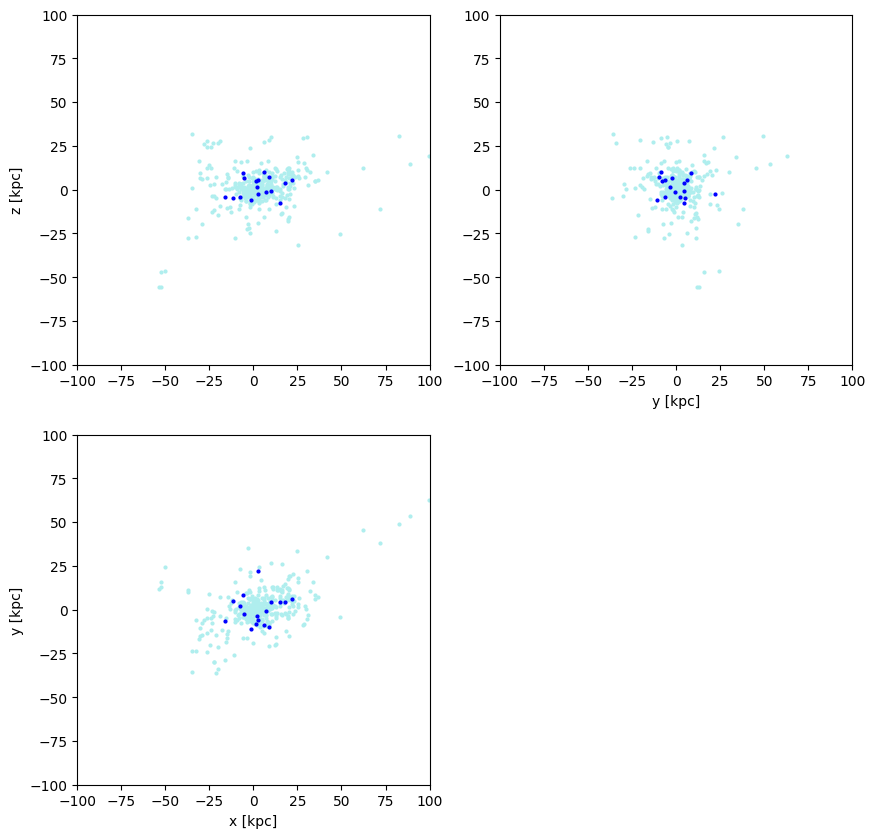

In [121]:
# type_check = ["in_situ_s", "in_situ_d", "ex_situ_s", "ex_situ_d"]
# type_check = ["in_situ_s", "in_situ_d"]
type_check = ["ex_situ_s", "ex_situ_d"]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for type_i, gc_type in enumerate(prop_dict.keys()):
    if gc_type in type_check:
        pos_xyz = prop_dict[gc_type]["pos.xyz"]
        x = pos_xyz[:, 0]
        y = pos_xyz[:, 1]
        z = pos_xyz[:, 2]

        axs[0, 0].scatter(x, z, s=plot_s[type_i], c=plot_c[type_i], zorder=plot_z[type_i])
        axs[0, 1].scatter(y, z, s=plot_s[type_i], c=plot_c[type_i], zorder=plot_z[type_i])
        axs[1, 0].scatter(x, y, s=plot_s[type_i], c=plot_c[type_i], zorder=plot_z[type_i])

for ax in axs.flat:
    ax.set_xlim([-100, 100])
    ax.set_ylim([-100, 100])

axs[1, 1].axis("off")

axs[0, 1].set_xlabel("y [kpc]")
axs[1, 0].set_xlabel("x [kpc]")

axs[0, 0].set_ylabel("z [kpc]")
axs[1, 0].set_ylabel("y [kpc]")

In [135]:
prop_dict["ex_situ_d"]["form_time"]

array([5.0118608 , 5.0118608 , 5.0118608 , 5.0118608 , 5.0118608 ,
       5.0118608 , 5.0118608 , 5.0118608 , 5.0118608 , 5.0118608 ,
       5.0118608 , 5.0118608 , 5.0118608 , 5.0118608 , 5.0118608 ,
       5.0118608 , 5.0118608 , 5.0118608 , 5.0118608 , 5.0118608 ,
       5.0118608 , 5.0118608 , 5.0118608 , 5.0118608 , 5.0118608 ,
       5.0118608 , 5.0118608 , 5.0118608 , 5.0118608 , 5.0118608 ,
       5.0118608 , 5.0118608 , 5.0118608 , 5.0118608 , 5.0118608 ,
       5.0118608 , 5.0118608 , 5.0118608 , 5.0118608 , 5.0118608 ,
       5.0118608 , 5.0118608 , 5.0118608 , 5.0118608 , 5.0118608 ,
       5.0118608 , 5.0118608 , 5.0118608 , 5.0118608 , 5.0118608 ,
       5.0118608 , 5.03724178, 5.03724178, 5.03724178, 5.03724178,
       5.03724178, 5.03724178, 5.03724178, 5.03724178, 5.03724178,
       5.03724178, 5.03724178, 5.03724178, 5.03724178, 5.03724178,
       5.03724178, 5.03724178, 5.03724178, 5.03724178, 5.03724178,
       5.03724178, 5.03724178, 5.03724178, 5.03724178, 5.03724

In [133]:
pop = np.where(sour_dat["gc_id"][ana_mask] == 59962304)[0][0]
sour_dat["snap_zform"][ana_mask][pop]

35

In [136]:
sour_dat["form_time"][ana_mask][pop]

0.690120165